In [2]:
### PREREQUISTIES
### (many used only in one notebook...)

import os
import pandas as pd
import numpy as np
import logging ### to monitor the code
from bs4 import BeautifulSoup
import pickle
import math
import random
import sys
import csv
import unicodedata
import requests
import re

import nltk
from nltk.collocations import *

import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats

import xml.etree.cElementTree as ET
from urllib.request import urlopen

import gspread
from gspread_dataframe import get_as_dataframe, set_with_dataframe
#from google.colab import auth
#from oauth2client.client import GoogleCredentials
from google.oauth2 import service_account # based on google-auth library
import sddk

In [3]:
#!pip install anda
#from anda import gr ### the import takes substantial time, since it import a +600MB file containing ancient Greek dictionary

In [5]:
### not neccessary for reading the data, just for exporting them to sciencedata.dk
conf = sddk.configure()

sciencedata.dk username (format '123456@au.dk'): 648597@au.dk
sciencedata.dk password: ········
endpoint variable has been configured to: https://sciencedata.dk/files/


In [6]:
# to access gsheet, you need Google Service Account key json file
# I have mine located in my personal space on sciencedata.dk, so I read it from there:

# (1) read the file and parse its content
file_data = conf[0].get(conf[1] + "ServiceAccountsKey.json").json()
# (2) transform the content into crendentials object
credentials = service_account.Credentials.from_service_account_info(file_data)
# (3) specify your usage of the credentials
scoped_credentials = credentials.with_scopes(['https://spreadsheets.google.com/feeds', 'https://www.googleapis.com/auth/drive'])
# (4) use the constrained credentials for authentication of gspread package
gc = gspread.Client(auth=scoped_credentials)
# (5) establish connection with spreadsheets specified by their url
PIA_data = gc.open_by_url("https://docs.google.com/spreadsheets/d/1KxOx7Be9fj3lDcEPgQhQ-Iqcn9p367-MMD6RMXe8rks/edit?usp=sharing")
PIA_overview = gc.open_by_url("https://docs.google.com/spreadsheets/d/1e94wyelg6dftQ4zxbq1xvwxWAI-BhcYXtclDW-YTnrw/edit?usp=sharing")

In [7]:
### our data are located within a publicly available folder on sciencedata.dk
publicfolder = "31b393e2afe1ee96ce81869c7efe18cb"
c_aristotelicum = sddk.read_file("c_aristotelicum_repl.json", "df", publicfolder)
c_hippocraticum = sddk.read_file("c_hippocraticum_repl.json", "df", publicfolder)

this file is located in a public folder
this file is located in a public folder


In [8]:
# replace title on the basis of manual coding
c_hip_metadata = PIA_overview.worksheet("c_hip_metadata").get_all_records()
c_hip_title_dict = {pair["doc_id"] : pair["title_latin"] for pair in c_hip_metadata}
c_hippocraticum["title"] = c_hippocraticum.apply(lambda row: c_hip_title_dict[row["doc_id"]], axis=1)

In [11]:
# replace title on the basis of manual coding
c_arist_metadata = PIA_overview.worksheet("c_arist_metadata").get_all_records()
c_arist_title_dict = {pair["doc_id"] : pair["title_latin"] for pair in c_arist_metadata}
c_aristotelicum["title"] = c_aristotelicum.apply(lambda row: c_arist_title_dict[row["doc_id"]], axis=1)

In [12]:
c_hippocraticum.head(5)

,filename,author,title,string,author_id,doc_id,raw_date,date_avr,date_probs,date_manual,provenience,wordcount,lemmata,lemmatized_sentences,lemmata_wordcount,num_of_sents,lemmata_repl,lemmatized_sentences_repl
1025,tlg0627.tlg001.perseus-grc1.xml,Hippocrates,De prisca medicina,ΠΕΡΙ ΑΡΧΑΙΗΣ ΙΗΤΡΙΚΗΣ ὁπόσοι μὲν ἐπεχείρησαν π...,tlg0627,tlg0627.tlg001,5-4 B.C.,-4.0,"{'-4.5': 0.5, '-3.5': 0.5}",-3.5,pagan,5537,"[ἀρχαῖος, ἰατρικός, ὁπόσος, ἐπιχειρέω, ἰητρικῆ...","[[ἀρχαῖος, ἰατρικός, ὁπόσος, ἐπιχειρέω, ἰητρικ...",2463,257,"[ἀρχαῖος, ἰατρικός, ὁπόσος, ἐπιχειρέω, ἰητρικῆ...","[[ἀρχαῖος, ἰατρικός, ὁπόσος, ἐπιχειρέω, ἰητρικ..."
1026,tlg0627.tlg002.perseus-grc1.xml,Hippocrates,De aëre aquis et locis,"ἰητρικὴν ὅστις βούλεται ὀρθῶς ζητεῖν, τάδε χρὴ...",tlg0627,tlg0627.tlg002,5-4 B.C.,-4.0,"{'-4.5': 0.5, '-3.5': 0.5}",-3.5,pagan,7502,"[ἰητρικην, βούλομαι, ὀρθός, ζητέω, χρῆ, ποιέω,...","[[ἰητρικην, βούλομαι, ὀρθός, ζητέω, χρῆ, ποιέω...",3393,461,"[ἰητρικην, βούλομαι, ὀρθός, ζητέω, χρῆ, ποιέω,...","[[ἰητρικην, βούλομαι, ὀρθός, ζητέω, χρῆ, ποιέω..."
1027,tlg0627.tlg003.perseus-grc1.xml,Hippocrates,Prognosticon,ΠΡΟΓΝΩΣΤΙΚΟΝ 1. τὸν ἰητρὸν δοκέει μοι ἄριστον ...,tlg0627,tlg0627.tlg003,5-4 B.C.,-4.0,"{'-4.5': 0.5, '-3.5': 0.5}",-3.5,pagan,5243,"[προγνωστικον, ἰατρός, δοκέω, ἁμός, ἄριστον, π...","[[προγνωστικον], [ἰατρός, δοκέω, ἁμός, ἄριστον...",2489,303,"[προγνωστικον, ἰατρός, δοκέω, ἁμός, ἄριστον, π...","[[προγνωστικον], [ἰατρός, δοκέω, ἁμός, ἄριστον..."
1028,tlg0627.tlg004.perseus-grc1.xml,Hippocrates,De diaeta in morbis acutis,ΠΕΡΙ ΔΙΑΙΤΗΣ ΟΞΕΩΝ 1. οἱ ξυγγράψαντες τὰς Κνιδ...,tlg0627,tlg0627.tlg004,5-4 B.C.,-4.0,"{'-4.5': 0.5, '-3.5': 0.5}",-3.5,pagan,6149,"[δίαιτα, ὄξος, ξυγγράψαντες, Κνίδιος, γνώμη, ὁ...","[[δίαιτα, ὄξος], [ξυγγράψαντες, Κνίδιος, γνώμη...",2983,370,"[δίαιτα, ὄξος, ξυγγράψαντες, Κνίδιος, γνώμη, ὁ...","[[δίαιτα, ὄξος], [ξυγγράψαντες, Κνίδιος, γνώμη..."
1029,tlg0627.tlg005.perseus-grc1.xml,Hippocrates,De diaeta acutorum (Sp.),"ΠΕΡΙ ΔΙΑΙΤΗΣ ΟΞΕΩΝ ΝΟΘΑ. 1. καῦσος γίγνεται, ὁ...",tlg0627,tlg0627.tlg005,5-4 B.C.,-4.0,"{'-4.5': 0.5, '-3.5': 0.5}",-3.5,pagan,5260,"[δίαιτα, ὄξος, νόθος, καῦσος, γίγνομαι, ὁκόταν...","[[δίαιτα, ὄξος, νόθος], [καῦσος, γίγνομαι, ὁκό...",2910,351,"[δίαιτα, ὄξος, νόθος, καῦσος, γίγνομαι, ὁκόταν...","[[δίαιτα, ὄξος, νόθος], [καῦσος, γίγνομαι, ὁκό..."


In [13]:
# patterns used in the replacement
keyterm_patterns = [("^λ[υ|ύ]π.+", "λύπ*"), ("^[ἀ|ἄ]λγ.+", "ἄλγ*"), ("^[ὀ|ὠ]δ[ύ|υ]ν.", "ὀδύν*"), ("^π[ό|ο]ν[ο|ό|έ|ε|η|ή|ῆ](?!ρ).+", "πόνο*")]

In [14]:
# make overview columns of individual terms accross documents
for pattern_tuple in keyterm_patterns:
  term = pattern_tuple[1] # eg. "λύπ*"
  c_aristotelicum[term] =  c_aristotelicum.apply(lambda row: row["lemmata_repl"].count(term), axis=1)
  c_hippocraticum[term] =  c_hippocraticum.apply(lambda row: row["lemmata_repl"].count(term), axis=1)
c_aristotelicum["terms_sum"] = c_aristotelicum.apply(lambda row: (row["λύπ*"] + row["ἄλγ*"] + row["ὀδύν*"] + row["πόνο*"]), axis=1)
c_hippocraticum["terms_sum"] = c_hippocraticum.apply(lambda row: (row["λύπ*"] + row["ἄλγ*"] + row["ὀδύν*"] + row["πόνο*"]), axis=1)

In [15]:
c_aristotelicum[["λύπ*", "ἄλγ*", "ὀδύν*", "πόνο*"]].sum()

λύπ*     391
ἄλγ*      32
ὀδύν*      3
πόνο*    100
dtype: int64

In [16]:
c_hippocraticum[["λύπ*", "ἄλγ*", "ὀδύν*", "πόνο*"]].sum()

λύπ*      58
ἄλγ*     315
ὀδύν*    642
πόνο*    651
dtype: int64

In [17]:
for term in ["λύπ*", "ἄλγ*", "ὀδύν*", "πόνο*"]:
  c_aristotelicum[term + "_weighted"] = c_aristotelicum.apply(lambda row: np.round(row[term] / row["wordcount"], 6), axis=1)
  c_hippocraticum[term + "_weighted"] = c_hippocraticum.apply(lambda row: np.round(row[term] / row["wordcount"], 6), axis=1)
c_aristotelicum["weighted_sum"] = c_aristotelicum.apply(lambda row: np.round((row["λύπ*"] + row["ἄλγ*"] + row["ὀδύν*"] + row["πόνο*"]) / row["wordcount"], 6), axis=1)
c_hippocraticum["weighted_sum"] = c_hippocraticum.apply(lambda row: np.round((row["λύπ*"] + row["ἄλγ*"] + row["ὀδύν*"] + row["πόνο*"]) / row["wordcount"], 6), axis=1)

In [25]:
# uncomment to export overview data to gsheet
#set_with_dataframe(PIA_overview.add_worksheet("c_aristotelicum_20200820",1,1), c_aristotelicum.drop(['string','lemmata', 'lemmatized_sentences', 'lemmatized_sentences_repl', 'lemmata_repl'], axis=1))
#set_with_dataframe(PIA_overview.add_worksheet("c_hippocraticum_20200820",1,1), c_hippocraticum.drop(['string','lemmata', 'lemmatized_sentences', 'lemmatized_sentences_repl', 'lemmata_repl'], axis=1))

# Selected works

In [18]:
# in what follows, we mainly focus upon a subselection of works from the two corpora
# we believe that these subselected works coverepresent the most relevant texts dealing with the topic of pain

ar_sel = ["tlg0086.tlg003", "tlg0086.tlg009", "tlg0086.tlg010", "tlg0086.tlg012", "tlg0086.tlg014", "tlg0086.tlg020", "tlg0086.tlg021", "tlg0086.tlg025", "tlg0086.tlg035", "tlg0086.tlg038"]
hip_sel = ["tlg0627.tlg001", "tlg0627.tlg003", "tlg0627.tlg006", "tlg0627.tlg009", "tlg0627.tlg012", "tlg0627.tlg017", "tlg0627.tlg019", "tlg0627.tlg031", "tlg0627.tlg032", "tlg0627.tlg033"]


In [19]:
# use these to filter within our dataframe
c_aristotelicum_10 = c_aristotelicum[c_aristotelicum["doc_id"].isin(ar_sel)]
c_hippocraticum_10 = c_hippocraticum[c_hippocraticum["doc_id"].isin(hip_sel)]

/srv/conda/envs/notebook/lib/python3.7/site-packages/IPython/core/pylabtools.py:132: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


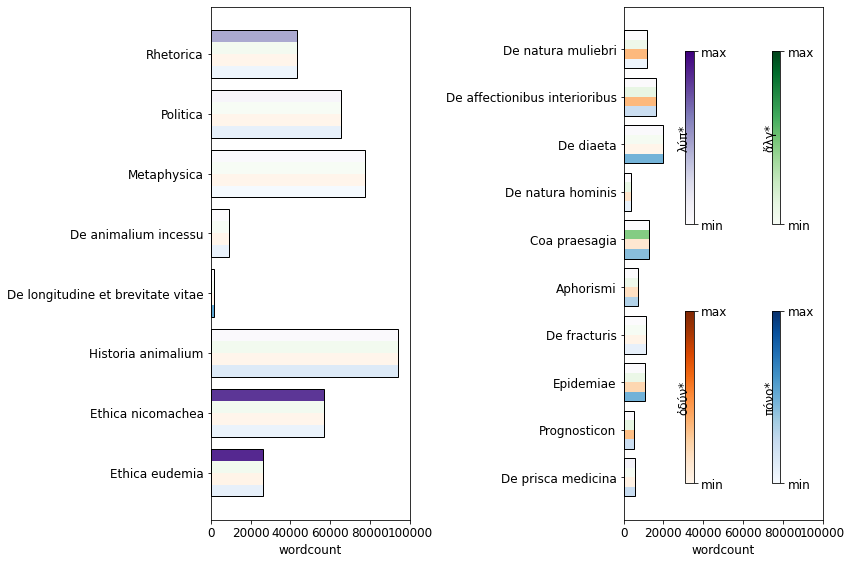

In [20]:
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm


# alternatively, choose 10 workds with maximal weighted sum of pain terms
#c_aristotelicum_10 = c_aristotelicum.sort_values("weighted_sum", ascending=False)[:10][::-1]
#c_hippocraticum_10 = c_hippocraticum.sort_values("weighted_sum", ascending=False)[:10][::-1]

# preproducing the figure object
fig, [ax1, ax2] = plt.subplots(1,2, figsize=(12, 8), tight_layout=True)

# CORPUS ARISTOTELICUM
labels = [title.partition(";")[0].partition(".")[0] for title in c_aristotelicum_10["title"].tolist()]
wordcounts = c_aristotelicum_10["wordcount"]
y = np.arange(len(labels))  # the label locations
width = 0.2  # the width of the bars

bar_location = 0
for keyterm, colormap in [("λύπ*", "Purples"), ("ἄλγ*", "Greens"), ("ὀδύν*", "Oranges"),	("πόνο*", "Blues")]:
  coloring = c_aristotelicum_10[keyterm + "_weighted"] / c_aristotelicum_10["weighted_sum"].max()
  ax1.barh(y + 0.3 - bar_location, wordcounts, width, color=plt.get_cmap(colormap)(coloring), label=keyterm)
  bar_location = bar_location + 0.2
ax1.barh(y, wordcounts, width * 4, color="none", edgecolor="black")
#rects2 = ax.barh(x + width/2, lemmata_wordcounts_1, width, label='Women')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax1.set_xlabel("wordcount")
#ax1.set_ylabel("documents")
ax1.set_yticks(y)
ax1.set_yticklabels(labels)
ax1.set_xlim(0, 100000)
# ax.legend()

# CORPUS HIPPOCRATICUM
labels = [title.partition(";")[0].partition(".")[0] for title in c_hippocraticum_10["title"].tolist()]
wordcounts = c_hippocraticum_10["wordcount"]
y = np.arange(len(labels))  # the label locations
width = 0.2  # the width of the bars

bar_location = 0
for keyterm, colormap in [("λύπ*", "Purples"), ("ἄλγ*", "Greens"), ("ὀδύν*", "Oranges"),	("πόνο*", "Blues")]:
  coloring = c_hippocraticum_10[keyterm + "_weighted"] / c_hippocraticum_10["weighted_sum"].max()
  cmap = plt.get_cmap(colormap)
  ax2.barh(y + 0.3 - bar_location, wordcounts, width, color=cmap(coloring), label=keyterm)
  bar_location = bar_location + 0.2



ax2.barh(y, wordcounts, width * 4, color="none", edgecolor="black")


#rects2 = ax.barh(x + width/2, lemmata_wordcounts_1, width, label='Women')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax2.set_xlabel("wordcount")
#ax2.set_ylabel("documents")
ax2.set_yticks(y)
ax2.set_yticklabels(labels)
ax2.set_xlim(0, 100000)
# ax.legend()

cblocs =    [[0.8, 0.6, 0.01, 0.3],# [left, bottom, width, height]
             [0.9, 0.6, 0.01, 0.3],
             [0.8, 0.15, 0.01, 0.3],
             [0.9, 0.15, 0.01, 0.3]
]

for keyterm, colormap, location in [("λύπ*", "Purples", cblocs[0]), ("ἄλγ*", "Greens", cblocs[1]), ("ὀδύν*", "Oranges", cblocs[2]),	("πόνο*", "Blues", cblocs[3])]:
  cmap = plt.get_cmap(colormap)
  sm = plt.cm.ScalarMappable(cmap=cmap)
  cbaxes = fig.add_axes(location) # [left, bottom, width, height]
  cb = plt.colorbar(sm, cax=cbaxes) #shrink=0.2) #, ticks=np.arange(0,n))
  cb.set_ticks([0,1])
  cb.set_ticklabels(["min", "max"])
  cb.set_label(keyterm, labelpad=-50)
  #plt.show()


#fig.tight_layout()

plt.show()

In [21]:
#uncomment to export:
#sddk.write_file("public_data/PIA/terms-colorbar.png", fig, conf)

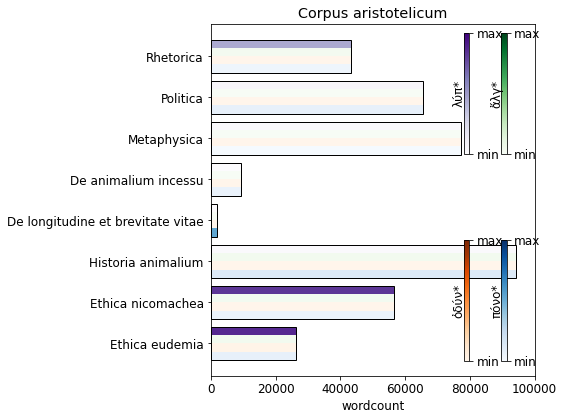

In [22]:
fig, ax = plt.subplots(figsize=(8, 6), tight_layout=True)

# CORPUS ARISTOTELICUM
labels = c_aristotelicum_10["title"].tolist()
wordcounts = c_aristotelicum_10["wordcount"]
y = np.arange(len(labels))  # the label locations
width = 0.2  # the width of the bars

bar_location = 0
for keyterm, colormap in [("λύπ*", "Purples"), ("ἄλγ*", "Greens"), ("ὀδύν*", "Oranges"), ("πόνο*", "Blues")]:
  coloring = c_aristotelicum_10[keyterm + "_weighted"] / c_aristotelicum_10["weighted_sum"].max()
  ax.barh(y + 0.3 - bar_location, wordcounts, width, color=plt.get_cmap(colormap)(coloring), label=keyterm)
  bar_location = bar_location + 0.2
ax.barh(y, wordcounts, width * 4, color="none", edgecolor="black")

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_title("Corpus aristotelicum")

ax.set_xlabel("wordcount")
#ax1.set_ylabel("documents")
ax.set_yticks(y)
ax.set_yticklabels(labels)
ax.set_xlim(0, 100000)
# ax.legend()

cblocs =    [[0.815, 0.63, 0.01, 0.28],# [left, bottom, width, height]
             [0.88, 0.63, 0.01, 0.28],
             [0.815, 0.15, 0.01, 0.28],
             [0.88, 0.15, 0.01, 0.28]]

for keyterm, colormap, location in [("λύπ*", "Purples", cblocs[0]), ("ἄλγ*", "Greens", cblocs[1]), ("ὀδύν*", "Oranges", cblocs[2]),	("πόνο*", "Blues", cblocs[3])]:
  cmap = plt.get_cmap(colormap)
  sm = plt.cm.ScalarMappable(cmap=cmap)
  cbaxes = fig.add_axes(location) # [left, bottom, width, height]
  cb = plt.colorbar(sm, cax=cbaxes) #shrink=0.2) #, ticks=np.arange(0,n))
  cb.set_ticks([0,1])
  cb.set_ticklabels(["min", "max"])
  cb.set_label(keyterm, labelpad=-50)


#fig.tight_layout()

plt.show()

In [ ]:
#uncomment to export:
sddk.write_file("public_data/PIA/terms-colorbar_arist.png", fig, conf)

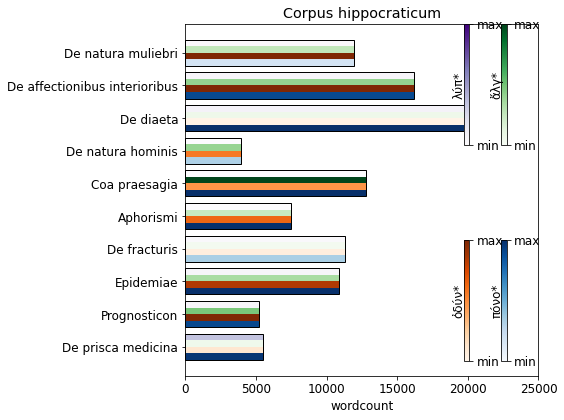

In [24]:
fig, ax = plt.subplots(figsize=(8, 6), tight_layout=True)

# CORPUS HIPPOCRATICUM
labels = c_hippocraticum_10["title"].tolist()
wordcounts = c_hippocraticum_10["wordcount"]
y = np.arange(len(labels))  # the label locations
width = 0.2  # the width of the bars

bar_location = 0
for keyterm, colormap in [("λύπ*", "Purples"), ("ἄλγ*", "Greens"), ("ὀδύν*", "Oranges"), ("πόνο*", "Blues")]:
  coloring = c_hippocraticum_10[keyterm + "_weighted"] / c_aristotelicum_10["weighted_sum"].max()
  ax.barh(y + 0.3 - bar_location, wordcounts, width, color=plt.get_cmap(colormap)(coloring), label=keyterm)
  bar_location = bar_location + 0.2
ax.barh(y, wordcounts, width * 4, color="none", edgecolor="black")
#rects2 = ax.barh(x + width/2, lemmata_wordcounts_1, width, label='Women')

ax.set_title("Corpus hippocraticum")
# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_xlabel("wordcount")
#ax1.set_ylabel("documents")
ax.set_yticks(y)
ax.set_yticklabels(labels)
ax.set_xlim(0, 25000)
# ax.legend()

cblocs =    [[0.815, 0.65, 0.01, 0.28],# [left, bottom, width, height]
             [0.88, 0.65, 0.01, 0.28],
             [0.815, 0.15, 0.01, 0.28],
             [0.88, 0.15, 0.01, 0.28]]

for keyterm, colormap, location in [("λύπ*", "Purples", cblocs[0]), ("ἄλγ*", "Greens", cblocs[1]), ("ὀδύν*", "Oranges", cblocs[2]),	("πόνο*", "Blues", cblocs[3])]:
  cmap = plt.get_cmap(colormap)
  sm = plt.cm.ScalarMappable(cmap=cmap)
  cbaxes = fig.add_axes(location) # [left, bottom, width, height]
  cb = plt.colorbar(sm, cax=cbaxes) #shrink=0.2) #, ticks=np.arange(0,n))
  cb.set_ticks([0,1])
  cb.set_ticklabels(["min", "max"])
  cb.set_label(keyterm, labelpad=-50)


#fig.tight_layout()

plt.show()

In [66]:
#uncomment to export:
sddk.write_file("public_data/PIA/terms-colorbar_hipp.png", fig, conf)

Your <class 'matplotlib.figure.Figure'> object has been succefully written as "https://sciencedata.dk/files/public_data/PIA/terms-colorbar_hipp.png"


# Pie charts (probably not used...)

/srv/conda/envs/notebook/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


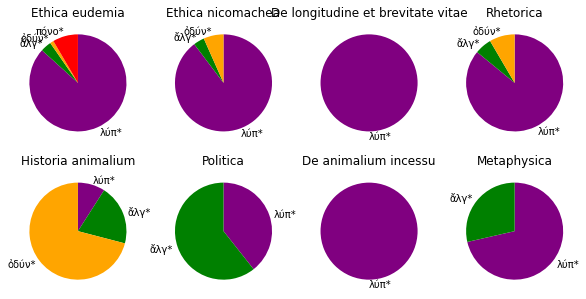

/srv/conda/envs/notebook/lib/python3.7/site-packages/ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


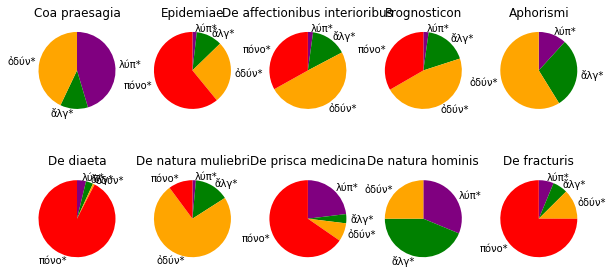

In [31]:
# PIE CHART (OF THE SAME DATA)

c_aristotelicum_10.sort_values("weighted_sum", ascending=False, inplace=True)

# Pie chart, where the slices will be ordered and plotted counter-clockwise:
titles = [title.partition(";")[0].partition(".")[0] for title in c_aristotelicum_10["title"].tolist()]
terms = ["λύπ*", "ἄλγ*","ὀδύν*", "πόνο*"]
#values = c_aristotelicum_10.iloc[n][["λύπ*_weighted", "ἄλγ*_weighted", "ὀδύν*_weighted", "πόνο*_weighted"]].tolist()


fig, axs  = plt.subplots(2, 4, figsize=(10,5))

for ax, n, title in zip(axs.ravel(), range(8), titles):
  values = c_aristotelicum_10.iloc[n][["λύπ*_weighted", "ἄλγ*_weighted", "ὀδύν*_weighted", "πόνο*_weighted"]].tolist()
  sizes = [val / c_aristotelicum_10.iloc[n]["weighted_sum"] * 100 for val in  values if val > 0]
  #labels = [term_value[0] + "(" + str(np.round(term_value[1], 4)) + ")" for term_value in zip(terms, values)]
  labels = terms
  ax.pie(sizes, colors=["purple", "green", "orange", "red"], labels=labels[:len(sizes)], startangle=90, counterclock=False)
  ax.set_title(title, wrap=True)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()


c_hippocraticum_10.sort_values("weighted_sum", ascending=False, inplace=True)

# Pie chart, where the slices will be ordered and plotted counter-clockwise:
titles = [title.partition(";")[0].partition(".")[0] for title in c_hippocraticum_10["title"].tolist()]
terms = ["λύπ*", "ἄλγ*","ὀδύν*", "πόνο*"]
values = c_hippocraticum_10.iloc[n][["λύπ*_weighted", "ἄλγ*_weighted", "ὀδύν*_weighted", "πόνο*_weighted"]].tolist()
fig, axs  = plt.subplots(2, 5, figsize=(10,5))


for ax, n, title in zip(axs.ravel(), range(10), titles):
  values = c_hippocraticum_10.iloc[n][["λύπ*_weighted", "ἄλγ*_weighted", "ὀδύν*_weighted", "πόνο*_weighted"]].tolist()
  sizes = [val / c_hippocraticum_10.iloc[n]["weighted_sum"] * 100 for val in  values if val > 0]
  #labels = [term_value[0] + "(" + str(np.round(term_value[1], 4)) + ")" for term_value in zip(terms, values)]
  labels = terms
  ax.pie(sizes, colors=["purple", "green", "orange", "red"], labels=labels[:len(sizes)], startangle=90, counterclock=False)
  ax.set_title(title, wrap=True)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()

# Combined barplot


In [32]:
category_colors = ["Purple", "Green", "Blue", "Red"]

In [33]:
def plot_ratios(corpus_df):
  data = {}
  for n in range(len(corpus_df)):
    label = corpus_df.iloc[n]["title"].partition(";")[0].partition(".")[0] + " (" + str(corpus_df.iloc[n]["wordcount"]) + " words)"
    counts = corpus_df.iloc[n][["λύπ*", "ἄλγ*", "ὀδύν*", "πόνο*"]].tolist()
    values = corpus_df.iloc[n][["λύπ*_weighted", "ἄλγ*_weighted", "ὀδύν*_weighted", "πόνο*_weighted"]].tolist()
    values = [0 if math.isnan(x) else x for x in values]
    ratios = [val / corpus_df.iloc[n]["weighted_sum"] * 100 for val in  values] # if val > 0]
    ratios = [0 if math.isnan(x) else x for x in ratios]
    data[label] = (counts, ratios)

  labels = list(data.keys())
  counts = np.array([el[0] for el in list(data.values())])
  ratios = np.array([el[1] for el in list(data.values())])
  ratios_cum = ratios.cumsum(axis=1)

  category_colors = ["Purple", "Green", "Blue", "Red"]

  terms = ["λύπ*", "ἄλγ*","ὀδύν*", "πόνο*"]


  fig, ax = plt.subplots(figsize=(12, len(corpus_df)/4 + 1), tight_layout=True)
  ax.invert_yaxis()
  ax.xaxis.set_visible(False)

  ax.set_xlim(0, np.sum(ratios, axis=1).max())
  ax.set_ylim(-0.5, len(corpus_df) - 0.5)

  for i, (term, color) in enumerate(zip(terms, category_colors)):
          widths = ratios[:, i]
          texts = counts[:, i]
          starts = ratios_cum[:, i] - widths
          ax.barh(labels, widths, left=starts,
                  label=term, color=color)
          xcenters = starts + widths / 2
          for y, (x, c) in enumerate(zip(xcenters, texts)):
              if int(c) > 0:
                ax.text(x, y, str(int(c)), ha='center', va='center', color='white')
              else:
                ax.text(x, y, "", ha='center', va='center', color='white')
  ax.legend(ncol=len(terms), bbox_to_anchor=(0, 1), loc='lower left', fontsize='small')
  return fig

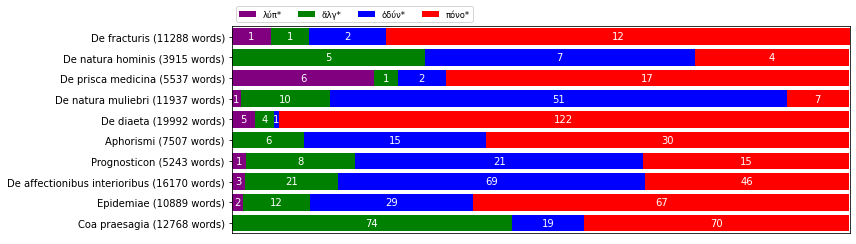

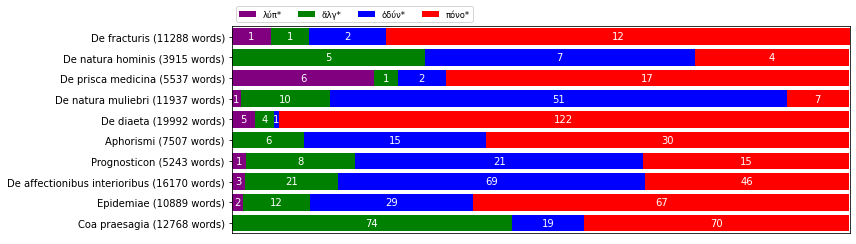

In [34]:
plot_ratios(c_hippocraticum_10)

/srv/conda/envs/notebook/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in double_scalars
  


A file with the same name ("ratios_c_hippocraticum.png") already exists in this location.


KeyboardInterrupt: Interrupted by user

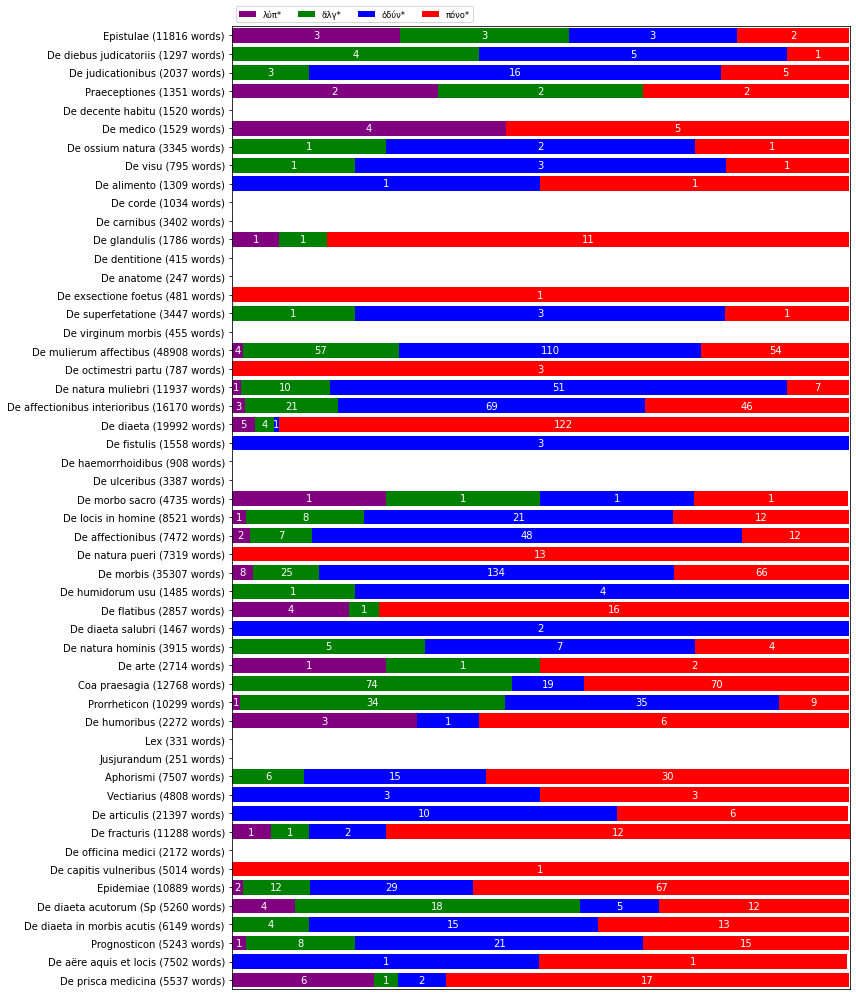

In [20]:
# uncomment to generate figures & export them to sciencedata
# sddk.write_file("public_data/PIA/ratios_c_aristotelicum.png", plot_ratios(c_aristotelicum), conf)
# sddk.write_file("public_data/PIA/ratios_c_aristotelicum_10.png", plot_ratios(c_aristotelicum_10), conf)
sddk.write_file("public_data/PIA/ratios_c_hippocraticum.png", plot_ratios(c_hippocraticum), conf)
sddk.write_file("public_data/PIA/ratios_c_hippocraticum_10.png", plot_ratios(c_hippocraticum_10), conf)

# Work types / document clustering

In [36]:
c_hip_metadata = PIA_overview.worksheet("c_hip_metadata").get_all_records()
c_hip_cat_dict = {pair["doc_id"] : pair["work_category"] for pair in c_hip_metadata}
print(c_hip_cat_dict)

{'tlg0627.tlg001': '(Anti)philosophical', 'tlg0627.tlg002': 'Itinerant physician', 'tlg0627.tlg003': 'Prognostics', 'tlg0627.tlg004': 'Prognostics', 'tlg0627.tlg005': 'Other (Jouanna 2005:66)', 'tlg0627.tlg006': 'Epidemics', 'tlg0627.tlg007': 'Surgical', 'tlg0627.tlg008': 'not specified', 'tlg0627.tlg009': 'Surgical', 'tlg0627.tlg010': 'Surgical', 'tlg0627.tlg011': 'Surgical', 'tlg0627.tlg012': 'Aphorisms', 'tlg0627.tlg013': 'Other (Jouanna 2005:66)', 'tlg0627.tlg014': 'Other (Jouanna 2005:66)', 'tlg0627.tlg015': 'Epidemics', 'tlg0627.tlg016': 'Other (Jouanna 2005:66)', 'tlg0627.tlg017': 'Cnidan ', 'tlg0627.tlg018': 'Later ', 'tlg0627.tlg019': '(Anti)philosophical', 'tlg0627.tlg020': 'Dietetics', 'tlg0627.tlg021': 'Other (Jouanna 2005:66)', 'tlg0627.tlg022': 'not specified', 'tlg0627.tlg023': 'Cnidan ', 'tlg0627.tlg024': 'Other (Jouanna 2005:66)', 'tlg0627.tlg025': 'Other (Jouanna 2005:66)', 'tlg0627.tlg026': 'Other (Jouanna 2005:66)', 'tlg0627.tlg027': 'Itinerant physician', 'tlg0627.

In [37]:
c_hippocraticum["work_cat"] = c_hippocraticum.apply(lambda row: c_hip_cat_dict[row["doc_id"]], axis=1)
c_hippocraticum.head(5)

,filename,author,title,string,author_id,doc_id,raw_date,date_avr,date_probs,date_manual,...,ἄλγ*,ὀδύν*,πόνο*,terms_sum,λύπ*_weighted,ἄλγ*_weighted,ὀδύν*_weighted,πόνο*_weighted,weighted_sum,work_cat
1025,tlg0627.tlg001.perseus-grc1.xml,Hippocrates,De prisca medicina,ΠΕΡΙ ΑΡΧΑΙΗΣ ΙΗΤΡΙΚΗΣ ὁπόσοι μὲν ἐπεχείρησαν π...,tlg0627,tlg0627.tlg001,5-4 B.C.,-4.0,"{'-4.5': 0.5, '-3.5': 0.5}",-3.5,...,1,2,17,26,0.001084,0.000181,0.000361,0.003070,0.004696,(Anti)philosophical
1026,tlg0627.tlg002.perseus-grc1.xml,Hippocrates,De aëre aquis et locis,"ἰητρικὴν ὅστις βούλεται ὀρθῶς ζητεῖν, τάδε χρὴ...",tlg0627,tlg0627.tlg002,5-4 B.C.,-4.0,"{'-4.5': 0.5, '-3.5': 0.5}",-3.5,...,0,1,1,2,0.000000,0.000000,0.000133,0.000133,0.000267,Itinerant physician
1027,tlg0627.tlg003.perseus-grc1.xml,Hippocrates,Prognosticon,ΠΡΟΓΝΩΣΤΙΚΟΝ 1. τὸν ἰητρὸν δοκέει μοι ἄριστον ...,tlg0627,tlg0627.tlg003,5-4 B.C.,-4.0,"{'-4.5': 0.5, '-3.5': 0.5}",-3.5,...,8,21,15,45,0.000191,0.001526,0.004005,0.002861,0.008583,Prognostics
1028,tlg0627.tlg004.perseus-grc1.xml,Hippocrates,De diaeta in morbis acutis,ΠΕΡΙ ΔΙΑΙΤΗΣ ΟΞΕΩΝ 1. οἱ ξυγγράψαντες τὰς Κνιδ...,tlg0627,tlg0627.tlg004,5-4 B.C.,-4.0,"{'-4.5': 0.5, '-3.5': 0.5}",-3.5,...,4,15,13,32,0.000000,0.000651,0.002439,0.002114,0.005204,Prognostics
1029,tlg0627.tlg005.perseus-grc1.xml,Hippocrates,De diaeta acutorum (Sp.),"ΠΕΡΙ ΔΙΑΙΤΗΣ ΟΞΕΩΝ ΝΟΘΑ. 1. καῦσος γίγνεται, ὁ...",tlg0627,tlg0627.tlg005,5-4 B.C.,-4.0,"{'-4.5': 0.5, '-3.5': 0.5}",-3.5,...,18,5,12,39,0.000760,0.003422,0.000951,0.002281,0.007414,Other (Jouanna 2005:66)


In [38]:
cats = sorted(c_hippocraticum["work_cat"].unique().tolist())
cats

['(Anti)philosophical',
 'Aphorisms',
 'Cnidan ',
 'Dietetics',
 'Epidemics',
 'Female medicine',
 'Itinerant physician',
 'Later ',
 'Other (Jouanna 2005:66)',
 'Prognostics',
 'Surgical',
 'not specified']

In [39]:
c_hippocraticum_by_cat = c_hippocraticum.groupby("work_cat").sum().drop(['date_avr', 'date_manual', "λύπ*_weighted", "ἄλγ*_weighted", "ὀδύν*_weighted", "πόνο*_weighted", 'weighted_sum'], axis=1)
c_hippocraticum_by_cat.reset_index(inplace=True)

In [40]:
for term in ["λύπ*", "ἄλγ*", "ὀδύν*", "πόνο*"]:
    c_hippocraticum_by_cat[term + "_weighted"] = c_hippocraticum_by_cat.apply(lambda row: np.round(row[term] / row["wordcount"], 6), axis=1)
c_hippocraticum_by_cat["weighted_sum"] = c_hippocraticum_by_cat.apply(lambda row: np.round((row["λύπ*"] + row["ἄλγ*"] + row["ὀδύν*"] + row["πόνο*"]) / row["wordcount"], 6), axis=1)

In [41]:
c_hippocraticum_by_cat

,work_cat,wordcount,lemmata_wordcount,num_of_sents,λύπ*,ἄλγ*,ὀδύν*,πόνο*,terms_sum,λύπ*_weighted,ἄλγ*_weighted,ὀδύν*_weighted,πόνο*_weighted,weighted_sum
0,(Anti)philosophical,9452,4193,443,6,6,9,21,42,0.000635,0.000635,0.000952,0.002222,0.004444
1,Aphorisms,8858,4735,694,2,8,15,32,57,0.000226,0.000903,0.001693,0.003613,0.006435
2,Cnidan,64245,33933,4412,11,120,222,182,535,0.000171,0.001868,0.003456,0.002833,0.008327
3,Dietetics,24861,12273,1704,5,4,3,122,134,0.000201,0.000161,0.000121,0.004907,0.005390
4,Epidemics,13161,7875,1362,5,12,30,73,120,0.000380,0.000912,0.002279,0.005547,0.009118
5,Female medicine,62087,35897,4173,5,67,161,64,297,0.000081,0.001079,0.002593,0.001031,0.004784
6,Itinerant physician,12237,5537,696,1,1,2,2,6,0.000082,0.000082,0.000163,0.000163,0.000490
7,Later,18613,9269,1165,8,4,3,9,24,0.000430,0.000215,0.000161,0.000484,0.001289
8,Other (Jouanna 2005:66),59730,30407,3917,13,78,140,95,326,0.000218,0.001306,0.002344,0.001590,0.005458
9,Prognostics,11392,5472,673,1,12,36,28,77,0.000088,0.001053,0.003160,0.002458,0.006759


In [ ]:
#set_with_dataframe(PIA_overview.add_worksheet("c_hippocraticum_by_cat", 1, 1), c_hippocraticum_by_cat)

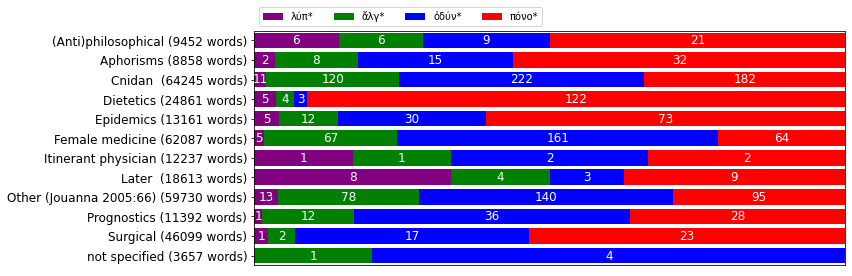

In [104]:
data = []
labels = []
counts = []
ratios = []

# reverse order:
c_hippocraticum_by_cat = c_hippocraticum_by_cat[::-1]

for n in range(len(c_hippocraticum_by_cat[::-1])):
    label = str(c_hippocraticum_by_cat.iloc[n]["work_cat"]) + " (" + str(c_hippocraticum_by_cat.iloc[n]["wordcount"]) + " words)"
    labels.append(label)
    cat_counts = c_hippocraticum_by_cat.iloc[n][["λύπ*", "ἄλγ*", "ὀδύν*", "πόνο*"]].tolist()
    counts.append(cat_counts)
    cat_ratios = [val / c_hippocraticum_by_cat.iloc[n]["terms_sum"] * 100 for val in  cat_counts] # if val > 0]
    cat_ratios = [0 if math.isnan(x) else x for x in cat_ratios]
    ratios.append(cat_ratios)

counts = np.array(counts)
ratios = np.array(ratios)
ratios_cum = ratios.cumsum(axis=1)

category_colors = ["Purple", "Green", "Blue", "Red"]

terms = ["λύπ*", "ἄλγ*","ὀδύν*", "πόνο*"]


fig, ax = plt.subplots(figsize=(12, (len(c_hippocraticum_by_cat) / 4) + 1), tight_layout=True)
ax.invert_yaxis()
ax.xaxis.set_visible(False)

ax.set_xlim(0, np.sum(ratios, axis=1).max())
ax.set_ylim(-0.5, len(c_hippocraticum_by_cat) - 0.5)

for i, (term, color) in enumerate(zip(terms, category_colors)):
          widths = ratios[:, i]
          texts = counts[:, i]
          starts = ratios_cum[:, i] - widths
          ax.barh(labels, widths, left=starts,
                  label=term, color=color)
          xcenters = starts + widths / 2
          for y, (x, c) in enumerate(zip(xcenters, texts)):
              if int(c) > 0:
                ax.text(x, y, str(int(c)), ha='center', va='center', color='white')
              else:
                ax.text(x, y, "", ha='center', va='center', color='white')
ax.legend(ncol=len(terms), bbox_to_anchor=(0, 1), loc='lower left', fontsize='small')

In [105]:
sddk.write_file("public_data/PIA/c_hip_ratios_by_cat.png", fig, conf)

A file with the same name ("c_hip_ratios_by_cat.png") already exists in this location.
Press Enter to overwrite it or choose different path and filename: 
Your <class 'matplotlib.figure.Figure'> object has been succefully written as "https://sciencedata.dk/files/public_data/PIA/c_hip_ratios_by_cat.png"


# Document distances

In [43]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import TruncatedSVD 
from sklearn.metrics.pairwise import cosine_similarity

In [44]:
c_hippocraticum.columns

Index(['filename', 'author', 'title', 'string', 'author_id', 'doc_id',
       'raw_date', 'date_avr', 'date_probs', 'date_manual', 'provenience',
       'wordcount', 'lemmata', 'lemmatized_sentences', 'lemmata_wordcount',
       'num_of_sents', 'lemmata_repl', 'lemmatized_sentences_repl', 'λύπ*',
       'ἄλγ*', 'ὀδύν*', 'πόνο*', 'terms_sum', 'λύπ*_weighted', 'ἄλγ*_weighted',
       'ὀδύν*_weighted', 'πόνο*_weighted', 'weighted_sum', 'work_cat'],
      dtype='object')

In [45]:
# as an input for vectorization, we need the documents in a form of strings
# we need two lists:
# (1) list of strings
# (2) list of work names
strings = [" ".join(lemmata) for lemmata in c_hippocraticum["lemmata"].tolist()]
titles = c_hippocraticum["title"].tolist()


In [46]:
def make_vec_df(list_of_string_docs, doc_names):
  vec = CountVectorizer()
  X = vec.fit_transform(list_of_string_docs)
  vectorization_df = pd.DataFrame(X.toarray(), columns=vec.get_feature_names(), index=doc_names)
  cosine_sim = cosine_similarity(X.toarray()) 
  cosine_sim_df = pd.DataFrame(np.round(cosine_sim, 5), columns=doc_names, index=doc_names)
  cosine_dist = 1 - cosine_similarity(X.toarray())
  cosine_dist_df = pd.DataFrame(np.round(cosine_dist, 5), columns=doc_names, index=doc_names)
  return [vectorization_df, cosine_sim_df, cosine_dist_df, doc_names]

In [47]:
c_hip_vec = make_vec_df(strings, titles)

In [48]:
c_hip_vec[0]

,άδες,άμα,έα,έκάτερα,έλκος,έᾷν,ήγο,ήμισαπές,ίνεται,αʼ,...,ῥᾷόν,ῥῆγμα,ῥῆμα,ῥῆξαί,ῥῆξις,ῥῆσις,ῥῖγος,ῥῖγός,ῥῖψις,ῥῦπος
De prisca medicina,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,2,0,0,0
De aëre aquis et locis,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
Prognosticon,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
De diaeta in morbis acutis,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
De diaeta acutorum (Sp.),0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Epidemiae,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,13,0,0,0
De capitis vulneribus,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
De officina medici,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
De fracturis,0,0,0,0,1,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
De articulis,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [49]:
c_hip_vec[2]

,De prisca medicina,De aëre aquis et locis,Prognosticon,De diaeta in morbis acutis,De diaeta acutorum (Sp.),Epidemiae,De capitis vulneribus,De officina medici,De fracturis,De articulis,...,De corde,De alimento,De visu,De ossium natura,De medico,De decente habitu,Praeceptiones,De judicationibus,De diebus judicatoriis,Epistulae
De prisca medicina,0.00000,0.42615,0.51021,0.48698,0.62581,0.58608,0.74151,0.71895,0.61764,0.52113,...,0.61965,0.66254,0.70615,0.80891,0.61788,0.59002,0.61646,0.60973,0.57877,0.46948
De aëre aquis et locis,0.42615,0.00000,0.50584,0.51305,0.51702,0.63764,0.71711,0.71667,0.63551,0.55593,...,0.64716,0.74548,0.66905,0.77473,0.66514,0.72991,0.69260,0.59645,0.52836,0.53167
Prognosticon,0.51021,0.50584,-0.00000,0.39590,0.40882,0.59425,0.65400,0.73515,0.46995,0.42105,...,0.73536,0.76434,0.58395,0.79520,0.65194,0.69081,0.64637,0.31696,0.42868,0.60848
De diaeta in morbis acutis,0.48698,0.51305,0.39590,-0.00000,0.41625,0.62396,0.69765,0.65535,0.46507,0.43833,...,0.69470,0.72051,0.63549,0.76964,0.59709,0.60787,0.55349,0.52332,0.51614,0.54848
De diaeta acutorum (Sp.),0.62581,0.51702,0.40882,0.41625,-0.00000,0.65476,0.68559,0.75519,0.55472,0.50525,...,0.73247,0.81100,0.56317,0.76951,0.75800,0.82220,0.69138,0.42504,0.42448,0.74153
Epidemiae,0.58608,0.63764,0.59425,0.62396,0.65476,0.00000,0.84415,0.77688,0.74182,0.71657,...,0.80785,0.77472,0.79094,0.83763,0.72575,0.68789,0.75466,0.51534,0.67762,0.66256
De capitis vulneribus,0.74151,0.71711,0.65400,0.69765,0.68559,0.84415,0.00000,0.76548,0.31814,0.43709,...,0.85257,0.81204,0.60938,0.78989,0.75550,0.83993,0.81684,0.73709,0.70301,0.79762
De officina medici,0.71895,0.71667,0.73515,0.65535,0.75519,0.77688,0.76548,0.00000,0.58531,0.55397,...,0.82582,0.75889,0.77080,0.72566,0.70205,0.81573,0.79027,0.77469,0.76787,0.74263
De fracturis,0.61764,0.63551,0.46995,0.46507,0.55472,0.74182,0.31814,0.58531,0.00000,0.18546,...,0.78396,0.75786,0.59036,0.71677,0.60267,0.65121,0.68598,0.65914,0.60940,0.66453
De articulis,0.52113,0.55593,0.42105,0.43833,0.50525,0.71657,0.43709,0.55397,0.18546,-0.00000,...,0.75112,0.74905,0.55837,0.66481,0.58605,0.65015,0.65291,0.59951,0.52832,0.60880


In [50]:
cats = [cat for cat in c_hippocraticum["work_cat"].tolist()]
cats

['(Anti)philosophical',
 'Itinerant physician',
 'Prognostics',
 'Prognostics',
 'Other (Jouanna 2005:66)',
 'Epidemics',
 'Surgical',
 'not specified',
 'Surgical',
 'Surgical',
 'Surgical',
 'Aphorisms',
 'Other (Jouanna 2005:66)',
 'Other (Jouanna 2005:66)',
 'Epidemics',
 'Other (Jouanna 2005:66)',
 'Cnidan ',
 'Later ',
 '(Anti)philosophical',
 'Dietetics',
 'Other (Jouanna 2005:66)',
 'not specified',
 'Cnidan ',
 'Other (Jouanna 2005:66)',
 'Other (Jouanna 2005:66)',
 'Other (Jouanna 2005:66)',
 'Itinerant physician',
 'Other (Jouanna 2005:66)',
 'Other (Jouanna 2005:66)',
 'Other (Jouanna 2005:66)',
 'Dietetics',
 'Cnidan ',
 'Female medicine',
 'Female medicine',
 'Female medicine',
 'Female medicine',
 'Other (Jouanna 2005:66)',
 'Other (Jouanna 2005:66)',
 'Surgical',
 'Other (Jouanna 2005:66)',
 'Other (Jouanna 2005:66)',
 'Dietetics',
 'Later ',
 'Other (Jouanna 2005:66)',
 'Other (Jouanna 2005:66)',
 'Surgical',
 'Later ',
 'Later ',
 'Aphorisms',
 'Other (Jouanna 2005:66

In [51]:
c_hippocraticum

,filename,author,title,string,author_id,doc_id,raw_date,date_avr,date_probs,date_manual,...,ἄλγ*,ὀδύν*,πόνο*,terms_sum,λύπ*_weighted,ἄλγ*_weighted,ὀδύν*_weighted,πόνο*_weighted,weighted_sum,work_cat
1025,tlg0627.tlg001.perseus-grc1.xml,Hippocrates,De prisca medicina,ΠΕΡΙ ΑΡΧΑΙΗΣ ΙΗΤΡΙΚΗΣ ὁπόσοι μὲν ἐπεχείρησαν π...,tlg0627,tlg0627.tlg001,5-4 B.C.,-4.0,"{'-4.5': 0.5, '-3.5': 0.5}",-3.5,...,1,2,17,26,0.001084,0.000181,0.000361,0.003070,0.004696,(Anti)philosophical
1026,tlg0627.tlg002.perseus-grc1.xml,Hippocrates,De aëre aquis et locis,"ἰητρικὴν ὅστις βούλεται ὀρθῶς ζητεῖν, τάδε χρὴ...",tlg0627,tlg0627.tlg002,5-4 B.C.,-4.0,"{'-4.5': 0.5, '-3.5': 0.5}",-3.5,...,0,1,1,2,0.000000,0.000000,0.000133,0.000133,0.000267,Itinerant physician
1027,tlg0627.tlg003.perseus-grc1.xml,Hippocrates,Prognosticon,ΠΡΟΓΝΩΣΤΙΚΟΝ 1. τὸν ἰητρὸν δοκέει μοι ἄριστον ...,tlg0627,tlg0627.tlg003,5-4 B.C.,-4.0,"{'-4.5': 0.5, '-3.5': 0.5}",-3.5,...,8,21,15,45,0.000191,0.001526,0.004005,0.002861,0.008583,Prognostics
1028,tlg0627.tlg004.perseus-grc1.xml,Hippocrates,De diaeta in morbis acutis,ΠΕΡΙ ΔΙΑΙΤΗΣ ΟΞΕΩΝ 1. οἱ ξυγγράψαντες τὰς Κνιδ...,tlg0627,tlg0627.tlg004,5-4 B.C.,-4.0,"{'-4.5': 0.5, '-3.5': 0.5}",-3.5,...,4,15,13,32,0.000000,0.000651,0.002439,0.002114,0.005204,Prognostics
1029,tlg0627.tlg005.perseus-grc1.xml,Hippocrates,De diaeta acutorum (Sp.),"ΠΕΡΙ ΔΙΑΙΤΗΣ ΟΞΕΩΝ ΝΟΘΑ. 1. καῦσος γίγνεται, ὁ...",tlg0627,tlg0627.tlg005,5-4 B.C.,-4.0,"{'-4.5': 0.5, '-3.5': 0.5}",-3.5,...,18,5,12,39,0.000760,0.003422,0.000951,0.002281,0.007414,Other (Jouanna 2005:66)
1030,tlg0627.tlg006.perseus-grc1.xml,Hippocrates,Epidemiae,ἐν Θάσῳ φθινοπώρου περὶ ἰσημερίην καὶ ὑπὸ πληι...,tlg0627,tlg0627.tlg006,5-4 B.C.,-4.0,"{'-4.5': 0.5, '-3.5': 0.5}",-3.5,...,12,29,67,110,0.000184,0.001102,0.002663,0.006153,0.010102,Epidemics
1031,tlg0627.tlg007.perseus-grc1.xml,Hippocrates,De capitis vulneribus,ΠΕΡΙ ΤΩΝ ΕΝ ΚΕΦΑΛΗ ΤΡΩΜΑΤΩΝ. 1. τῶν ἀνθρώπων α...,tlg0627,tlg0627.tlg007,5-4 B.C.,-4.0,"{'-4.5': 0.5, '-3.5': 0.5}",-3.5,...,0,0,1,1,0.000000,0.000000,0.000000,0.000199,0.000199,Surgical
1032,tlg0627.tlg008.perseus-grc1.xml,Hippocrates,De officina medici,ΚΑΤʼ ΙΗΤΡΕΙΟΝ. 1. ἢ ὅμοια ἢ ἀνόμοια ἐξ ἀρχῆς· ...,tlg0627,tlg0627.tlg008,5-4 B.C.,-4.0,"{'-4.5': 0.5, '-3.5': 0.5}",-3.5,...,0,0,0,0,0.000000,0.000000,0.000000,0.000000,0.000000,not specified
1033,tlg0627.tlg009.perseus-grc1.xml,Hippocrates,De fracturis,ΠΕΡΙ ΑΓΜΩΝ. 1. ἐχρῆν τὸν ἰητρὸν τῶν ἐκπτωσίων ...,tlg0627,tlg0627.tlg009,5-4 B.C.,-4.0,"{'-4.5': 0.5, '-3.5': 0.5}",-3.5,...,1,2,12,16,0.000089,0.000089,0.000177,0.001063,0.001417,Surgical
1034,tlg0627.tlg010.perseus-grc1.xml,Hippocrates,De articulis,ΠΕΡΙ ΑΡΘΡΩΝ 1. ὤμου δὲ ἄρθρον ἕνα τρόπον οἶδα ...,tlg0627,tlg0627.tlg010,5-4 B.C.,-4.0,"{'-4.5': 0.5, '-3.5': 0.5}",-3.5,...,0,10,6,16,0.000000,0.000000,0.000467,0.000280,0.000748,Surgical


In [52]:
# to get colors based on work category

# (1) for each document category generate a random color
#color_pairs = {}
#for cat in sorted(c_hippocraticum["work_cat"].unique().tolist()):
#    color_pairs[cat] = np.random.rand(3,)

# OR
# (2) assign colors manually
color_pairs = {
    '(Anti)philosophical' : "b", #: blue
    'Itinerant physician' : "g", #: green
    'Prognostics' : "r", #: red
    'Epidemics' : "c",#: cyan
    'Surgical' : "m", #: magenta
    'Aphorisms' : "y", # : yellow
    'Cnidan ' : "k", #: black
    'Later ' : "darkorange",
    'Dietetics' : "pink",
    'Female medicine' : "purple",
    'Other (Jouanna 2005:66)'  : "darkgrey",
    'not specified' : "lightgrey"}
    
# use these colors to assign color to each document
colors = [color_pairs[pair] for pair in cats]

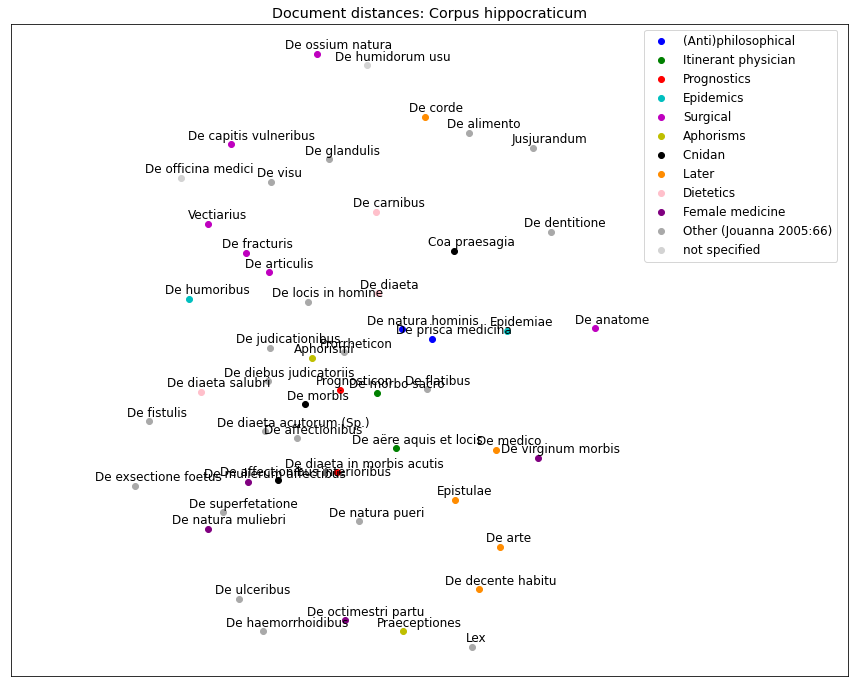

In [62]:
import matplotlib.pyplot as plt
from sklearn.manifold import MDS

plt.rcParams['figure.figsize'] = (15.0, 12.0)
plt.rcParams.update({'font.size': 12})

mds = MDS(n_components=2, random_state=1, dissimilarity='precomputed') # dissimilarity="precomputed",


fig, ax = plt.subplots()

# we need to transform the indovidual distances into a 2-dimensional space
# mds = MDS(n_components=2, dissimilarity="precomputed", random_state=0)
pos = mds.fit_transform(c_hip_vec[2])
xs, ys = pos[:, 0], pos[:, 1]
# to have the plot big enough, we will modify default size of all generated plots
# (original is 6 to 4 inches)
#fig = plt.figure()
# now we can plot the distances transformed via the mds function as a scatter plot
for x, y, name, color in zip(xs, ys, c_hip_vec[2].columns, colors):
    ax.scatter(x, y, c=np.array([color]))
    x = x- (0.006 * len(name))
    ax.text(x, y+0.01, name)
ax.set_xlim(-1,1.5)
ax.set_title("Document distances: Corpus hippocraticum")
ax.axes.get_xaxis().set_visible(False)
ax.axes.get_yaxis().set_visible(False)

markers = [plt.Line2D([0,0],[0,0],color=color, marker='o', linestyle='') for color in color_pairs.values()]
plt.legend(markers, color_pairs.keys(), numpoints=1,  bbox_to_anchor=(0.75, 1), loc='upper left')
#plt.legend(color_pairs.values(), color_pairs.keys(), bbox_to_anchor=(1, 1), loc='upper left')

In [63]:
sddk.write_file("public_data/PIA/c_hip_distances.png", fig, conf)

A file with the same name ("c_hip_distances.png") already exists in this location.
Press Enter to overwrite it or choose different path and filename: 
Your <class 'matplotlib.figure.Figure'> object has been succefully written as "https://sciencedata.dk/files/public_data/PIA/c_hip_distances.png"
